# Приоритизация гипотез и анализ А/В теста для интернет-магазина

# Описание проекта

В нашем распоряжении данные крупного интернет-магазина, в том числе список гипотез для увеличения выручки.
Для принятия решений нам необходимо приоритизировать гипотезы,а так же проанализировать результаты A/B-теста.

# Описание данных
**Данные для первой части**

Файл /datasets/hypothesis.csv.
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Данные для второй части**

Файл /datasets/orders.csv. 
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста


In [1]:
import pandas as pd
import datetime as dt
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

## Приоритизация гипотез.


In [2]:
data = pd.read_csv('/datasets/hypothesis.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
# Приведем названия столбцов к хорошему стилю (переведем наименования в нижний регистр)
data.columns = data.columns.str.lower()
pd.options.display.max_colwidth = 130
data

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Чтобы провести приоритизацию гипотез будем использовать фреймворки ***ICE*** (от английского impact, confidence, effort / ease «влияние, уверенность, усилия / простота») и ***RICE*** - модификация метода ICE, при которой учитывается еще и охват пользователей (от английского reach, «охват»).

### Применим фреймворк ICE для приоритизации гипотез.

In [4]:
data['ICE'] = round(data['impact']*data['confidence']/data['efforts'], 2)
# отсортируем их по убыванию приоритета и выведем столбцы с гипотезами и ICE
data[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Видим, что самый высокий ICE у гипотезы 9 - "Запустить акцию, дающую скидку на товар в день рождения", далее идут гипотезы 1 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей" и 8 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".  

### Применим фреймворк RICE для приоритизации гипотез. 

In [5]:
data['RICE'] = data['reach']*data['impact']*data['confidence']/data['efforts']
# отсортируем их по убыванию приоритета и выведем столбцы с гипотезами и RICE
data[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Здесь уже другая картина: лидирует гипотеза 8 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" (3-е место по величине ICE), на втором месте гипотеза 3 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	", при этом отрыв от лидера 100%.
Такое значение получилось, потому что уровень reach	8 гипотезы 10 баллов - максимально возможное.

In [6]:
# выведем все полученные данные в одной таблице
data = data[['hypothesis', 'ICE', 'RICE']]
data

,hypothesis,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.2


## Анализ А/В-теста

### Рассмотрим данные и информацию о них.

In [7]:
visitors, orders = (pd.read_csv('/datasets/visitors.csv'),
                   pd.read_csv('/datasets/orders.csv'))

Для начала рассмотрим информацию о данных и сами данные.

In [8]:
# Создадим функцию для вывода информации о датафреймах
def information (name):
    return name.info(), 'Пропуски данных:', name.isna().sum(), 'Дубликаты:', name.duplicated().sum(), name.head()

In [9]:
information(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


(None,
 'Пропуски данных:',
 date        0
 group       0
 visitors    0
 dtype: int64,
 'Дубликаты:',
 0,
          date group  visitors
 0  2019-08-01     A       719
 1  2019-08-02     A       619
 2  2019-08-03     A       507
 3  2019-08-04     A       717
 4  2019-08-05     A       756)

In [10]:
information(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


(None,
 'Пропуски данных:',
 transactionId    0
 visitorId        0
 date             0
 revenue          0
 group            0
 dtype: int64,
 'Дубликаты:',
 0,
    transactionId   visitorId        date  revenue group
 0     3667963787  3312258926  2019-08-15     1650     B
 1     2804400009  3642806036  2019-08-15      730     B
 2     2961555356  4069496402  2019-08-15      400     A
 3     3797467345  1196621759  2019-08-15     9759     B
 4     2282983706  2322279887  2019-08-15     2308     B)

Видим, что типы данных верные, дубликатов и пропусков нет, наименования столбцов соответствуют хорошему стилю.

### Подготовим данные для проведения А/В-теста

In [11]:
# приведем дату к нужному виду
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [12]:
# посчитаем количество пользователей в каждой группе
groups = orders.groupby('group').agg({'visitorId': pd.Series.nunique})
groups

,visitorId
group,
A,503
B,586


In [13]:
groups.sum()

visitorId    1089
dtype: int64

In [14]:
# узнаем сколько у нас всего пользователей
orders['visitorId'].nunique()


1031

Видим, что уникальных id 1031, а всего участников в группах 1089, из этого следует, что некоторые пользователи попали и в группу А, и в группу В. Для принятия решений по данным пользователям, посчитаем какой их процент.

In [15]:
round(groups.sum()/orders['visitorId'].nunique()-1, 3)

visitorId    0.056
dtype: float64

5.6% пользователей попали в обе группы одновременно. Скорей всего это покупатели, которые совершили более одной покупки. Изучим данных пользователей позже, когда будим очищать наши данные от аномалий, а пока сохраним их Id в списке.

In [16]:
usersFromGroupA = orders[orders['group'] == 'A']['visitorId']
usersFromGroupB = orders[orders['group'] == 'B']['visitorId']
list(set(usersFromGroupA).intersection(set(usersFromGroupB)))

[3957174400,
 3984495233,
 2780786433,
 1294878855,
 1648269707,
 1614305549,
 4120364173,
 232979603,
 199603092,
 4266935830,
 2712142231,
 2587333274,
 2716752286,
 3891541246,
 1668030113,
 2654030115,
 3234906277,
 1230306981,
 1404934699,
 3803269165,
 2949041841,
 237748145,
 457167155,
 2927087541,
 1738359350,
 3062433592,
 3656415546,
 818047933,
 393266494,
 963407295,
 471551937,
 2579882178,
 3202540741,
 2686716486,
 1333886533,
 2044997962,
 3941795274,
 1801183820,
 2378935119,
 4256040402,
 4069496402,
 3766097110,
 8300375,
 351125977,
 1602967004,
 276558944,
 2038680547,
 3951559397,
 3963646447,
 4186807279,
 3717692402,
 1959144690,
 2458001652,
 2600415354,
 2954449915,
 1316129916,
 477780734,
 3972127743]

In [17]:
id = [3957174400,
 3984495233,
 2780786433,
 1294878855,
 1648269707,
 1614305549,
 4120364173,
 232979603,
 199603092,
 4266935830,
 2712142231,
 2587333274,
 2716752286,
 3891541246,
 1668030113,
 2654030115,
 3234906277,
 1230306981,
 1404934699,
 3803269165,
 2949041841,
 237748145,
 457167155,
 2927087541,
 1738359350,
 3062433592,
 3656415546,
 818047933,
 393266494,
 963407295,
 471551937,
 2579882178,
 3202540741,
 2686716486,
 1333886533,
 2044997962,
 3941795274,
 1801183820,
 2378935119,
 4256040402,
 4069496402,
 3766097110,
 8300375,
 351125977,
 1602967004,
 276558944,
 2038680547,
 3951559397,
 3963646447,
 4186807279,
 3717692402,
 1959144690,
 2458001652,
 2600415354,
 2954449915,
 1316129916,
 477780734,
 3972127743]

In [18]:
# создадим датафрейм с уникальными парами значений 'date' и 'group', удалим возможные дубликаты
datesGroups = orders[['date', 'group']].drop_duplicates()


Соберём агрегированные кумулятивные по дням данные о заказах.

In [19]:
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, 
# а группа теста равна группе из datesGroups, вычислим max дату и найдем число уникальных пользователей
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,# применим методы к каждой строке датафрейма
).sort_values(by=['date', 'group']) # отсортируем результат

# так же поступим с датафреймом visitors
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединим датафреймы, переименуем столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Проверим корректно ли создан датафрейм, для этого рассмотрим минимальные и максимальные даты датафрейма и исходных данных.

In [20]:
print('Максимальная дата исходных данных: ', orders['date'].max())

Максимальная дата исходных данных:  2019-08-31 00:00:00


In [21]:
print('Минимальная дата исходных данных: ', orders['date'].min())

Минимальная дата исходных данных:  2019-08-01 00:00:00


In [22]:
print('Максимальная дата нового датафрейма: ', cumulativeData['date'].max())

Максимальная дата нового датафрейма:  2019-08-31 00:00:00


In [23]:
print('Минимальная дата нового датафрейма: ', cumulativeData['date'].min())

Минимальная дата нового датафрейма:  2019-08-01 00:00:00


Даты совпадают, датафрейм создан корректно.

In [24]:
# объявим переменные с кумулятивными данными по группам
cumulativeGroupA = cumulativeData[cumulativeData['group'] =="A"][['date','revenue', 'orders']]
cumulativeGroupB = cumulativeData[cumulativeData['group'] =="B"][['date','revenue', 'orders']]

### Построим график кумулятивной выручки по группам

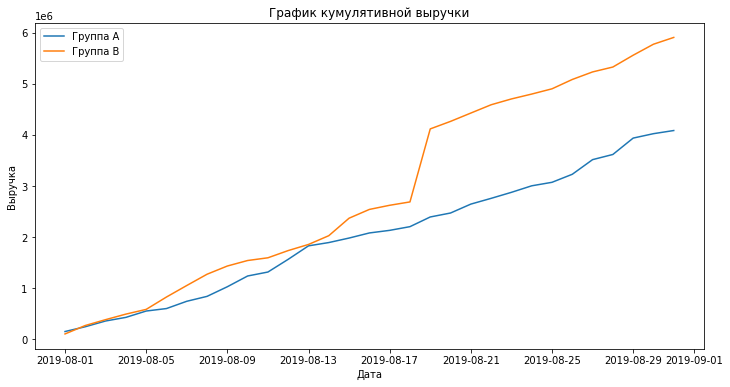

In [25]:
# построим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeGroupA['date'], cumulativeGroupA['revenue'], label='A')
plt.plot(cumulativeGroupB['date'], cumulativeGroupB['revenue'], label='B')

plt.legend(['Группа А', 'Группа В'])
plt.title('График кумулятивной выручки')
plt.xlabel('Дата')
plt.ylabel('Выручка');

Из графика видно, что выручка по группе А равномерно увеличивается в ходе теста, а вот выручка группы В сначала увеличивается равномерно, но примерно 19 августа происходит значительный скачок, после которого выручка так же равномерно продолжает расти. Данный всплеск может быть обусловлен ростом количества заказов или наличием дорогих заказов.

### Построим график кумулятивного среднего чека по группам. 

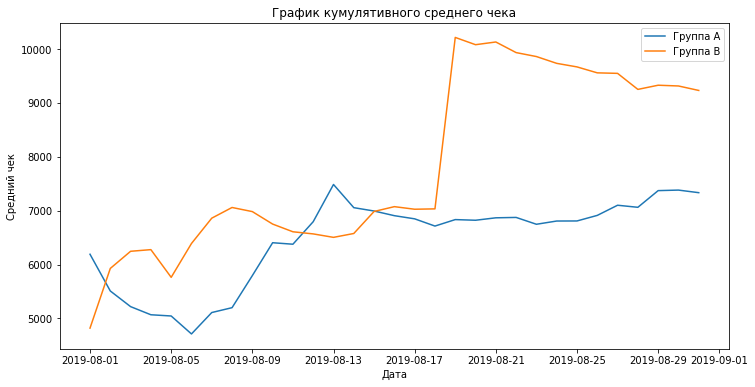

In [26]:
# построим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeGroupA['date'], cumulativeGroupA['revenue']/cumulativeGroupA['orders'], label='A')
plt.plot(cumulativeGroupB['date'], cumulativeGroupB['revenue']/cumulativeGroupB['orders'], label='B')

plt.legend(['Группа А', 'Группа В'])
plt.title('График кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Средний чек');

Данные графика по кумулятивному среднему чеку подтверждают наши наблюдения - 19 августа произошел скачок размера среднего чека группы В, а после 18 августа средняя стоиомсть чека начала снижатьсяб что свидетельствует о наличии дорогой покупки в этот день.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

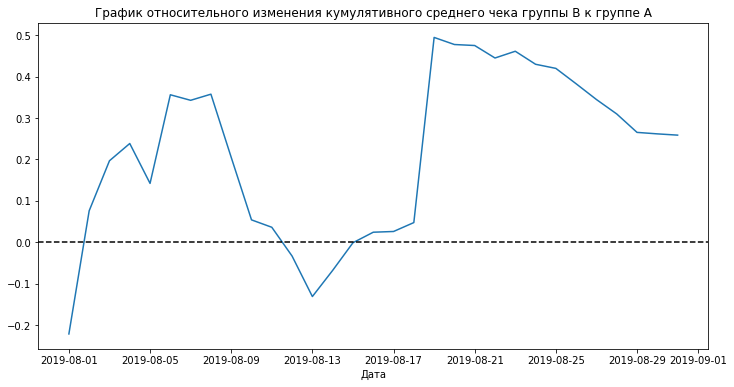

In [27]:
# собирем кумулятивные данные в одном датафрейме
mergedCumulativeRevenue = cumulativeGroupA.merge(cumulativeGroupB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# построим график относительного изменения
plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы В к группе А')
plt.xlabel('Дата');

По графики видно, что изначально средний чек группы В проигрывал группе А, но потом поизошел рост с падением 13 августа и снова рост, уже без падений до конца срока наблюдений. И опять мы видим аномальный рост 19 августа, что свидетельствует о дорогой покупке. 


### Построим график кумулятивной конверсии по группам. 

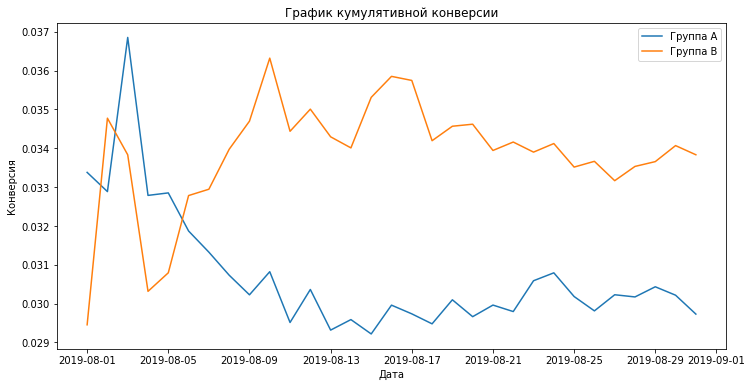

In [28]:
# посчитаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# сохраним в переменных отдельно данные по группе А и группе В
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.legend(['Группа А', 'Группа В'])
plt.title('График кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Конверсия');

Видим, что после падения 4 августа конверсия группы В намного выше чем у группы А, которая ухудшается после 3 августа.

### Построим график относительного изменения кумулятивной конверсии группы B к группе A. 

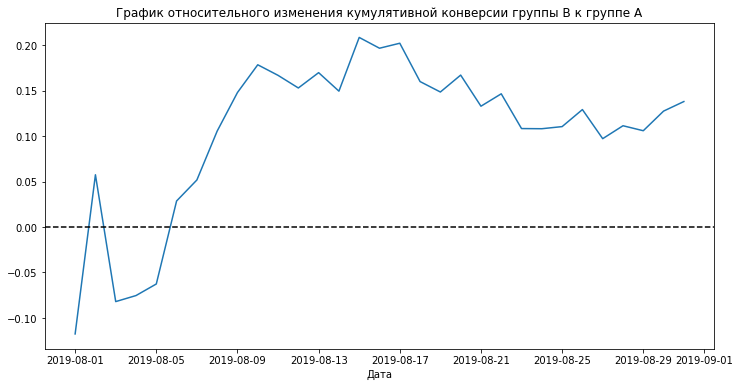

In [29]:
# собирем кумулятивные данные в одном датафрейме
mergedCumulativeConversion = cumulativeDataA.merge(cumulativeDataB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
# построим график относительного изменения
plt.figure(figsize=(12, 6))
plt.plot(mergedCumulativeConversion['date'], (mergedCumulativeConversion['conversionB']/mergedCumulativeConversion['conversionA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивной конверсии группы В к группе А')
plt.xlabel('Дата');

По графику можно увидеть, что группа В практически сразу начала показывать лучший результат по кумулятивной конверсии чем группа А, у группы В было падение конверсии в начале иследований, но потом отмечается резкий рост. К концу срока исследования отношение конверсии группы В к группе А снизилось относительно пиковых показателей, но все равно достаточно высоко.

### Построим точечный график количества заказов по пользователям. 

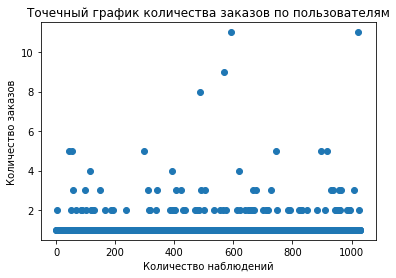

In [30]:
# объявим переменную, в которой посчитаем количество заказов по каждому пользователю
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId': 'nunique'})
ordersByUsers.columns= ['userId', 'orders']

# построим точечный график
x_values = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество наблюдений')
plt.ylabel('Количество заказов');

По графику выдно, что в основном у каждого пользователя по 1 заказу, чуть менее пользователей, у которых по 2 заказа, но так же встречаются выбросы - у пользователей более 10 заказов.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [31]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Видим, что всего 5% пользователей сделали более 2 заказов и всего 1% - более 4. Границу аномальных пользователей целесообразно установить на уровне 2, то есть 95 перцентиль.

In [32]:
# сохраним в переменной значение 95 перцентиля
percentile_orders = int(np.percentile(ordersByUsers['orders'], [95]))


### Построим точечный график стоимостей заказов. 

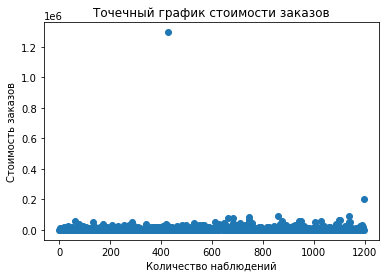

In [33]:
# оценим стоимость заказов, построив точечный график
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимости заказов')
plt.xlabel('Количество наблюдений')
plt.ylabel('Стоимость заказов');

Из графика видно, что основная часть заказов достаточно схожих по стоимости, но есть несколько выбивающихся из общей картины.

### Посчитаем 95-й и 99-й перцентили стоимости заказов. 

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Видим, что 5% заказов от 28000 и всего 1% - от 58233.2. Разумно установить границу для определения аномальной стоимости заказов на уровне 58233.2, т.е. 99 перцентиль.

In [35]:
# сохраним в переменной значение 99 перцентиля
percentile_revenue = float(np.percentile(orders['revenue'], [99]))

### Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

Сформулируем гипотезы:
* нулевая гипотеза - различий в конверсии между группами нет;
* альтернативная гипотеза - различия в конверсии между группами есть.

Так как у нас не очень большой объем данных для исследования (1196 строк), то примим уровень статистической значимости равный 0,05.

In [36]:
# объявим переменные, в которых укажем количество заказов
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

# объявим переменные, в которых пользователям из разных групп будет соответствовать количество заказов
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0,index=np.arange(visitors[visitors['group']=='A']['visitors'].sum()
                    - len(ordersByUsersA['orders'])),name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0,index=np.arange(visitors[visitors['group']=='B']['visitors'].sum()
                   - len(ordersByUsersB['orders'])), name='orders',),], axis=0,)


print('p-значение', '{0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Различие в конверсии группы В к конверсии группы А:', '{0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-значение 0.017
Различие в конверсии группы В к конверсии группы А: 0.138


Первое получившееся значение это р-значение, которое меньше 0.05, значит нулевую гипотезу о том, что нет различий в конверсии между группами, отвергаем.
Конверсия группы В на 13.8% выше конверсии группы А.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы:

* нулевая гипотеза - различий в среднем чеке между группами нет;
* альтернативная гипотеза - различия среднем чеке между группами есть.

Уровень статистической значимости - 0,05.

In [37]:

print('p-значение', '{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'],\
                                                        orders[orders['group'] == 'B']['revenue'])[1]))

print('Различие в среднем чеке группы В к среднему чеку группы А:', '{0:.3f}'\
      .format(orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean() - 1))

p-значение 0.729
Различие в среднем чеке группы В к среднему чеку группы А: 0.259


p-значение равно 0,729, что больше уровня статистической значимости, поэтому у нас не получилсь отвергнуть нулевую гипотезу и получается, что различий в среднем чеке между группами нет. Величина среднего чека в группе В на 25.9% выше среднего чека группы А. Здесь мы опять видим подтвержение наших выводов по графику кумулятивного среднего чека по группам.  

### Очистим данные от аномальных значений.

На предыдущих этапах мы определили границу аномальных пользователей по количеству заказов на уровне 2, а аномальной стоимости заказов на уровне 58233.2.

In [38]:
# Узнаем сколько в данных аномальных пользователей
# для начала отберем данные, не входящие в установленные границы аномальных пользователей
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > percentile_orders]['userId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > percentile_orders]['userId'],
],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue']>percentile_revenue]['visitorId']

# объединим аномальных пользователей
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

abnormalUsers.shape[0]

31

Видим, что аномальных пользователей в наших данных 31.

In [39]:
# проверим совпадают ли id аномальных пользователей с id пользователей, вошедших в обе группы
listId = 0
for x in abnormalUsers:
    if x in id:
        listId+=1
listId

15

Видим, что 15 пользователей, которые входят и в группу А и в группу В являются аномальными и мы от них избавляемся при "очищении" данных. Чтобы более четко проанлизировать аномальных покупателей, не будем на этапе подготовки данных, удалять данных покупателей (п.2.2).

In [40]:
# очистим данные от аномалий
dataFilteredA = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA ['userId'].isin(abnormalUsers))]['orders'], 
                           pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum()
                    - len(ordersByUsersA['orders'])),name='orders')], axis=0)
dataFilteredB = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB ['userId'].isin(abnormalUsers))]['orders'], 
                           pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum()
                    - len(ordersByUsersB['orders'])),name='orders')], axis=0)

### Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным. 

In [41]:
print('p-значение:', '{0:.3f}'.format(stats.mannwhitneyu(dataFilteredA, dataFilteredB)[1]))

print('Различия в конверсии группы В к конверсии группы А:', '{0:.3f}'.format(dataFilteredB.mean() / dataFilteredA.mean() - 1))

p-значение: 0.010
Различия в конверсии группы В к конверсии группы А: 0.174


р-значение очищенных данных стало даже меньше чем р-значение первоначальных данных и оно также меньше 0.05, значит нулевую гипотезу о том, что нет различий в конверсии между группами отвергаем.
Конверсия группы В по очищенным данным так же выше чем конверсии группы А (17.4%).

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [42]:
print('р-значение:', '{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',np.logical_not(
    orders['visitorId'].isin(abnormalUsers)),)]['revenue'], orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'],)[1]))

print('Различие в среднем чеке группы В к среднему чеку группы А:', '{0:.3f}'.format(orders[np.logical_and(orders['group'] == 'B',np.logical_not(
    orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()/ orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),)]['revenue'].mean()- 1)) 

р-значение: 0.798
Различие в среднем чеке группы В к среднему чеку группы А: -0.020


р-значение по очищенным данным так же больше уровня статистической значимости, поэтому нам не удалось отвергнуть нулевую гипотезу и значит, что различий между средними чеками между группами нет.

А вот отношение средних чеков между группами по очищенным данным значительно поменялось: по полным данным группа В на 25.9% больше, чем средний чек группы А, а по очищенным данным средний чек группы В меньше на 2% среднего чека группы А. Это говорит, о том, что в группе В были аномальные дорогие покупки, от которых мы очистили данные.

***Подведем итоги:***
* различия между конверсией между группами А и В есть как в "сырых" так и в очищенных данных;
* различий в среднем чеке между группами как по "сырым" так и по очищенным данным нет;
* конверсия группы В выше чем конверсия группы А (в "сырых" данных на 13.8%, по очищенным на 17.4%)
* по "сырым" данным средний чек группы В на 25.9% больше среднего чека группы А, а по очищенным данным средний чек группы В уже меньше на 2% чем у группы А.

***Вывод:***
Можно остановить тест и признать выигрывшей группу В, так как, хотя средний чек очищенных данных группы В чуть ниже данного показателя группы А, но ее конверсия как в "сырых", так и в очищенных данных выше на 13.8% и 17.4% соответственно.